# The Influence of Urban Environmental and Socioeconomic Variables on Childhood Obesity Prevalence: A Case Study of London

------
- Code is hosted [here](https://github.com/JialeiGuo1108/Childhood_Obesity)

- Data is available [here](https://github.com/JialeiGuo1108/Childhood_Obesity/tree/main/data)

- Number of words: ***

- Runtime: *** hours (*Memory 10 GB, CPU Intel i7-10700 CPU @2.90GHz*)

- Coding environment: SDS Docker

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).
--------


## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

<font color=#6495ED>请使用Python笔记本模板Template_ submission_CASA0006.ipynb来格式化您的提交，并在提交前删除指令句。

以下部分应包含在本笔记本中：

• 引言

• 研究问题 • 数据。

• 方法论

• 结果与讨论

• 结论

• 参考文献

在引言中，您需要包括至少三个相关研究。在“研究问题”中，您需要明确陈述以问号结尾的问题。例如，“Covid-19死亡率与英国当地贫困之间的关系是什么？”或“是否可以使用英国的社会人口变量预测Covid-19死亡率？”

笔记本需要一个标题。

## Introduction

[[ go back to the top ]](#Table-of-contents)

Childhood obesity is a growing public health concern, with environmental factors such as green space accessibility and fast-food outlet density potentially playing significant roles.

Childhood obesity is a public health concern.

Obesity for children and adolescents was defined as BMI for age at or above the 95th percentile based on the Centers for Disease Control and Prevention growth chart.

## Research questions

[[ go back to the top ]](#Table-of-contents)

- RQ1 | How do environmental factors—specifically green space coverage and fast-food outlet density—collectively influence childhood obesity rates across London wards?
- RQ2 | Which environmental factor (green space or fast-food density) has a stronger relative impact on obesity rates?

## Data

[[ go back to the top ]](#Table-of-contents)

### Data sources

The basic information about the resolution, temporal domain, type, and source of the data is shown in Table 1. The detailed description of the data is as follows.

| Name                            | Temporal domain | Type | Source |
|:---------------------------------|:------------------|:------|:--------|
|Reception prevalence of obesity (including severe obesity), 3 years data combined(Indicator_ID:93105) | 2021/22-2023/24         | csv     | https://fingertips.phe.org.uk/profile/national-child-measurement-programme/data#page/6/gid/1938133288/pat/401/par/E09000019/ati/3/are/E02000573/iid/93105/age/200/sex/4/cat/-1/ctp/-1/yrr/3/cid/1/tbm/1/page-options/ovw-do-0_car-do-0 |
| Fast food outlets by ward       | 2024             | ods  |https://assets.publishing.service.gov.uk/media/67a0e46682f8431ebeb047ca/Fast_food_supporting_information.ods |
| Green Cover                     | 2024             | elsx | https://data.london.gov.uk/download/green-cover-2024/2a993c9b-20c5-43c6-871b-ce5e5aa5376a/2024_%20green_cover_borough_ward_stats.xlsx |
| London Wards                    | 2018             | shp  | https://data.london.gov.uk/download/statistical-gis-boundary-files-london/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip |

<font color=#DE3163>补充Description

- 通过fingertips导入childhood obesity相关数据
  
由于London DataStore里面关于child obesity的MSoa和ward层面的数据只有到2011/12 to 2013/14，所以本次研究数据是通过[Fingertips的API](https://fingertips.phe.org.uk/api#/Data)获取的2021/22-2023/24年的4-5岁的child obesity数据（ward层面）https://fingertips.phe.org.uk/profile/national-child-measurement-programme/data#page/6/gid/1938133288/pat/159/par/K02000001/ati/15/are/E92000001/yrr/1/cid/4/tbm/1 defination
https://fingertips.phe.org.uk/api/all_data/csv/for_one_indicator?indicator_id=93105,
由于API接口不稳定，所以接下去使用的child obesity数据皆为下载后存在repo内的数据

### Data loading and exploration

In this article, used Python libraries are listed as follows:

In [1]:
# for recording runtime
import time
import psutil
import platform
import subprocess

start_time = time.time()

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# feature importance（PFI）
import rfpimp

import seaborn as sns

# GBDT
import xgboost
from xgboost import XGBRegressor

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [3]:
# check the library version before we start
print("xgboost version:{}".format(xgboost.__version__))
print("sklearn version:{}".format(sklearn.__version__))

xgboost version:2.1.1
sklearn version:1.5.2


In [4]:
# import the childhood obesity dataset
url_child_obesity = "https://raw.githubusercontent.com/JialeiGuo1108/Childhood_Obesity/refs/heads/main/data/child_obesity.csv"
child_obesity = pd.read_csv(url_child_obesity)

# modify column names
child_obesity.columns = child_obesity.columns.str.replace(' ', '_').str.lower()

/tmp/ipykernel_97082/3864357092.py:3: DtypeWarning: Columns (9,10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  child_obesity = pd.read_csv(url_child_obesity)


In [5]:
# show the first few rows of the data
print(child_obesity.head())

   indicator_id                                     indicator_name  \
0         93105  Reception prevalence of obesity (including sev...   
1         93105  Reception prevalence of obesity (including sev...   
2         93105  Reception prevalence of obesity (including sev...   
3         93105  Reception prevalence of obesity (including sev...   
4         93105  Reception prevalence of obesity (including sev...   

  parent_code parent_name  area_code            area_name area_type      sex  \
0         NaN         NaN  E92000001              England   England  Persons   
1   E92000001     England  E02000001       City of London      MSOA  Persons   
2   E92000001     England  E02000002           Marks Gate      MSOA  Persons   
3   E92000001     England  E02000003  Chadwell Heath East      MSOA  Persons   
4   E92000001     England  E02000004         Eastbrookend      MSOA  Persons   

       age category_type  ...                                    count  \
0  4-5 yrs           NaN

In [6]:
# screen out the data needed
# 1. area_type == "Electoral Wards (2021)"
# 2. time_period == "2021/22 - 23/24"
child_obesity_2124 = child_obesity[
    (child_obesity['area_type'] == 'Electoral Wards (2021)') & 
    (child_obesity['time_period'] == '2021/22 - 23/24')
]


print(child_obesity_2124.head(3))
# filtered data is stored in the repo（https://raw.githubusercontent.com/JialeiGuo1108/Childhood_Obesity/refs/heads/main/data/filtered_child_obesity.csv）

        indicator_id                                     indicator_name  \
219753         93105  Reception prevalence of obesity (including sev...   
219754         93105  Reception prevalence of obesity (including sev...   
219755         93105  Reception prevalence of obesity (including sev...   

       parent_code parent_name  area_code  area_name               area_type  \
219753   E92000001     England  E05000026      Abbey  Electoral Wards (2021)   
219754   E92000001     England  E05000027     Alibon  Electoral Wards (2021)   
219755   E92000001     England  E05000028  Becontree  Electoral Wards (2021)   

            sex      age category_type  ...  \
219753  Persons  4-5 yrs           NaN  ...   
219754  Persons  4-5 yrs           NaN  ...   
219755  Persons  4-5 yrs           NaN  ...   

                                          count  \
219753                                  95.0000   
219754                                  70.0000   
219755                              

In [7]:
green_cover = pd.read_excel('https://github.com/JialeiGuo1108/Childhood_Obesity/raw/refs/heads/main/data/2024_%20green_cover_borough_ward_stats.xlsx',sheet_name='Ward')
green_cover.head(3)

,ward,ward_code,ward_area_ha,ward_green_sum,percentage,see Methodology Report for margins of error - https://data.london.gov.uk/dataset/green-cover-2024
0,Harold Wood,E05013973,907.6860,642.7571,0.7081,NaN
1,Bromley Town,E05013991,334.2670,160.4244,0.4799,NaN
2,Mayfield,E05011248,186.2176,60.0281,0.3224,NaN


In [8]:
#if the data cannot be read, run the next line of code
#!pip install odfpy
fast_food=pd.read_excel('https://github.com/JialeiGuo1108/Childhood_Obesity/raw/refs/heads/main/data/Fast_food_supporting_information.ods', 
                        sheet_name='Table1', 
                        engine='odf', 
                        skiprows=3)

In [9]:
# modify column names
fast_food.columns = fast_food.columns.str.replace(' ', '_').str.lower()
fast_food.head(3)

,local_authority_code,local_authority_name,ward_code,ward_name,count_of_outlets
0,E06000001,Hartlepool,E05013038,Burn Valley,21
1,E06000001,Hartlepool,E05013039,De Bruce,8
2,E06000001,Hartlepool,E05013040,Fens & Greatham,7


In [10]:
usual_residents=pd.read_excel('https://github.com/JialeiGuo1108/Childhood_Obesity/raw/refs/heads/main/data/usual_residents_london_2021.xlsx', 
                        sheet_name='2021')
# modify column names
usual_residents.columns = usual_residents.columns.str.replace(' ', '_').str.lower()

In [42]:
usual_residents.head(3)

,ward_code,ward_name,local_authority_code,local_authority_name,all_usual_residents,females,males,lives_in_a_household,lives_in_a_communal_establishment,area;_hectares,density;_persons_per_hectare
0,E09000001,City of London (aggregated),E09000001,City of London,8579,3862,4717,8379,210,NaN,NaN
1,E05014053,Abbey,E09000002,Barking and Dagenham,3965,1945,2020,3959,0,NaN,NaN
2,E05014054,Alibon,E09000002,Barking and Dagenham,9890,5130,4760,9809,70,NaN,NaN


In [11]:
household_deprivation=pd.read_excel('https://github.com/JialeiGuo1108/Childhood_Obesity/raw/refs/heads/main/data/Household_deprivation.xlsx', 
                        sheet_name='2021')
# modify column names
household_deprivation.columns = household_deprivation.columns.str.replace(' ', '_').str.lower()

In [12]:
household_deprivation.head(3)

,ward_code,ward_name,local_authority_code,local_authority_name,all_households,deprived_in:_no_dimensions,1_dimension,2_dimensions,3_dimensions,4_dimensions
0,E09000001,City of London (aggregated),E09000001,City of London,4909,2937,1547,343,75,7
1,E05014053,Abbey,E09000002,Barking and Dagenham,1460,604,568,221,62,5
2,E05014054,Alibon,E09000002,Barking and Dagenham,3344,1302,1246,612,173,11


## Methodology

[[ go back to the top ]](#Table-of-contents)

### Study design
This study employs a cross-sectional observational design to analyze the association between urban environmental variables (green space coverage, fast-food outlet density), socioeconomic factors (household deprivation), and childhood obesity prevalence across London wards. I combine geospatial data aggregation with machine learning techniques to quantify predictive relationships.

The following flowchart illustrates the steps needed to produce the results using the machine learning.

![Figure 1: Overall Process](https://github.com/JialeiGuo1108/Childhood_Obesity/blob/main/flowchart.png?raw=true)

### Variables
| Varibles                               | Description |
|:----------------------------------------|:------------------|
|Childhood obesity prevalence (%) at ward level | The proportion of children aged 4 to 5 years classified as living with obesity.  For population monitoring purposes, a child’s body mass index (BMI) is classed as overweight or obese where it is on or above the 85th centile or 95th centile, respectively, based on the British 1990 (UK90) growth reference data.        |
|Fast food outlets per 100,000 population       | The number of fast food outlets is divided by the population of usual resident in the ward and multiplied by 100,000.            |
|Green space coverage(%)                    | The total number of green cover is divided by the area of the ward.        |
|Household deprivation index (%)                   | The number of households that are deprived in two dimensions is divided by the number of all households.    |

### Data Processing
针对变量`fast_food`, `child_obesity`提取伦敦ward范围

`green_cover`,`usual_resident` and `household_deprivation`内的数据并清理不需要的列

In [14]:
# WD21CD to WD22CD
mapping_df = pd.read_csv('ward_code_spatial_mapping.csv')

# check the structure of the mapping table
print("Mapping table columns:", mapping_df.columns.tolist())
print("First few rows of the mapping table:", mapping_df.head())

Mapping table columns: ['WD21CD', 'WD22CD', 'distance']
First few rows of the mapping table:       WD21CD     WD22CD                                 distance
0  E05000026  E05014066                                   0.0026
1  E05000027  E05014054                                   0.0119
2  E05000028  E05014057                                   0.0021
3  E05000029  E05014058                                   0.0000
4  E05000030  E05014059                                   0.0018


In [15]:
# 第三步：将映射应用到child_obesity数据集
child_obesity_2124_mapped = pd.merge(
    child_obesity_2124,
    mapping_df[['WD21CD', 'WD22CD']],
    left_on='area_code',  # child_obesity中的WD21CD列
    right_on='WD21CD',
    how='left'
)

In [16]:
# 检查映射结果
mapped_count = child_obesity_2124_mapped['WD22CD'].notna().sum()
total_count = len(child_obesity_2124_mapped)
print(f"在child_obesity数据集中，{mapped_count}/{total_count}条记录被成功匹配到2022选区代码")

在child_obesity数据集中，7007/7007条记录被成功匹配到2022选区代码


In [17]:
child_obesity_2124_mapped.head(6)

,indicator_id,indicator_name,parent_code,parent_name,area_code,area_name,area_type,sex,age,category_type,...,value_note,recent_trend,compared_to_england_value_or_percentiles,column_not_used,time_period_sortable,new_data,compared_to_goal,time_period_range,WD21CD,WD22CD
0,93105,Reception prevalence of obesity (including sev...,E92000001,England,E05000026,Abbey,Electoral Wards (2021),Persons,4-5 yrs,NaN,...,NaN,Cannot be calculated,Worse,Not compared,20210000,NaN,NaN,3y,E05000026,E05014066
1,93105,Reception prevalence of obesity (including sev...,E92000001,England,E05000027,Alibon,Electoral Wards (2021),Persons,4-5 yrs,NaN,...,NaN,Cannot be calculated,Worse,Not compared,20210000,NaN,NaN,3y,E05000027,E05014054
2,93105,Reception prevalence of obesity (including sev...,E92000001,England,E05000028,Becontree,Electoral Wards (2021),Persons,4-5 yrs,NaN,...,NaN,Cannot be calculated,Worse,Not compared,20210000,NaN,NaN,3y,E05000028,E05014057
3,93105,Reception prevalence of obesity (including sev...,E92000001,England,E05000029,Chadwell Heath,Electoral Wards (2021),Persons,4-5 yrs,NaN,...,NaN,Cannot be calculated,Worse,Not compared,20210000,NaN,NaN,3y,E05000029,E05014058
4,93105,Reception prevalence of obesity (including sev...,E92000001,England,E05000030,Eastbrook,Electoral Wards (2021),Persons,4-5 yrs,NaN,...,NaN,Cannot be calculated,Worse,Not compared,20210000,NaN,NaN,3y,E05000030,E05014059
5,93105,Reception prevalence of obesity (including sev...,E92000001,England,E05000031,Eastbury,Electoral Wards (2021),Persons,4-5 yrs,NaN,...,NaN,Cannot be calculated,Worse,Not compared,20210000,NaN,NaN,3y,E05000031,E05014060


In [18]:
# 第四步：使用2022年代码合并child_obesity和household_deprivation
merged_0= green_cover.merge(
    child_obesity_2124_mapped,
    left_on='ward_code',
    right_on='WD22CD',  # household_deprivation中的WD22CD列
    how='inner'
)

In [85]:
merged_0.shape

(639, 35)

In [32]:
fast_food.shape

(6326, 5)

In [31]:
green_cover.shape

(704, 6)

In [19]:
# merge green_cover and fast_food
merged_data = green_cover.merge(fast_food, on='ward_code', how='left')
# then merge with usual_residents
merged_data_2 = merged_data.merge(usual_residents, on='ward_code', how='left')
# then merge with household_deprivation
merged_data_3 = merged_data_2.merge(household_deprivation, on='ward_code', how='left')
merged_data_3.shape

# then merge with child_obesity_2124
merged_data_4= merged_data_3.merge(child_obesity_2124_mapped, left_on='ward_code', right_on='WD22CD', how='inner')
merged_data_4.shape

(639, 58)

In [67]:
all_data = merged_data_4.copy()

# calculate the index: Fast food outlets per 100,000 population
all_data['fast_food_outlets_percentage'] = all_data['count_of_outlets']/all_data['all_usual_residents']*100000

# calculate the index: Household deprivation index (%)
all_data['2_household_deprivation'] = all_data['deprived_in:_no_dimensions']/all_data['all_households']*100

# calculate the index: Green space coverage(%)
all_data['green_space_coverage'] = all_data['percentage']*100


In [68]:
# create a clean DataFrame only containing ward code, name and four main indicators
variables = pd.DataFrame({
    'ward_code': all_data['ward_code'],
    'ward_name': all_data['ward'], 
    'fast_food_outlets': all_data['fast_food_outlets_percentage'],  
    'household_deprivation': all_data['2_household_deprivation'],  
    'green_space_coverage': all_data['green_space_coverage'],  
    'child_obesity': all_data['value']  # Child obesity rate
})

In [69]:
variables.head(5)

,ward_code,ward_name,fast_food_outlets,household_deprivation,green_space_coverage,child_obesity
0,E05013973,Harold Wood,93.1766,52.3784,70.8127,6.7961
1,E05013991,Bromley Town,221.1551,58.9361,47.9929,7.6923
2,E05011248,Mayfield,43.7719,43.0150,32.2354,14.0351
3,E05013968,Cranham,53.9915,52.8086,61.9750,7.0588
4,E05014119,West Dulwich,60.6744,56.8788,43.6431,8.6957


In [70]:
# Feature Engineering
# select relevant features
features = ['green_space_coverage', 
           'fast_food_outlets',
           'household_deprivation']  

target = 'child_obesity'


# remove rows containing missing values
data = variables.dropna(subset=features + [target])

In [71]:
# split the dataset
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:
# build the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [74]:
# cross-validation evaluation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation MSE: {-cv_scores.mean():.4f}, Standard deviation: {cv_scores.std():.4f}")

Cross-validation MSE: 5.2473, Standard deviation: 0.3833


In [75]:
# train the model
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [76]:
# feature importance
importance = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importance)[::-1]

print("\nFeature importance:")
for i in range(len(feature_names)):
    print(f"{feature_names[indices[i]]}: {importance[indices[i]]:.4f}")


Feature importance:
household_deprivation: 0.5995
fast_food_outlets: 0.2142
green_space_coverage: 0.1863


In [77]:
# test set evaluation
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nTest set MSE: {mse:.4f}")
print(f"Test set R²: {r2:.4f}")


Test set MSE: 5.5705
Test set R²: 0.4801


In [36]:
plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

Text(0.5, 1.0, 'Feature importance')

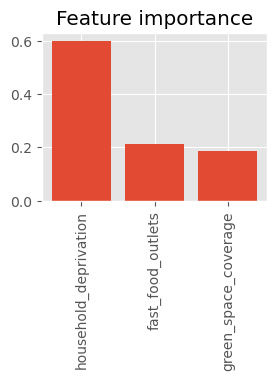

In [78]:
# feature importance visualization
plt.subplot(2, 2, 1)
plt.bar(range(len(indices)), importance[indices], align='center')
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.title('Feature importance')

Text(0.5, 1.0, 'Predicted vs Actual value')

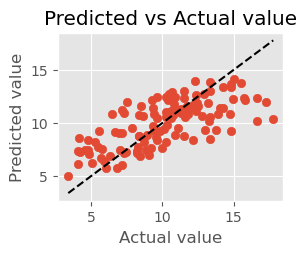

In [79]:
# prediction vs actual value
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.title('Predicted vs Actual value')

Text(0.5, 1.0, 'Feature Correlation')

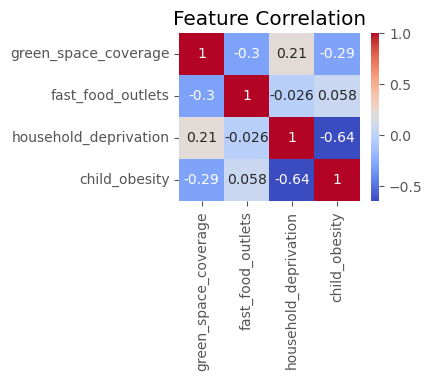

In [80]:
# correlation heatmap
plt.subplot(2, 2, 3)
correlation = data[features + [target]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation')

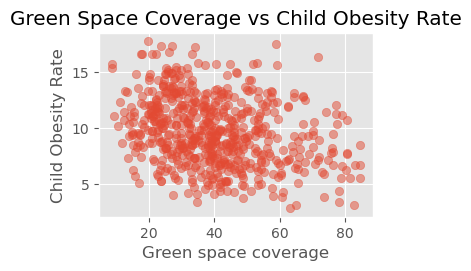

In [81]:
# Green space coverage vs obesity rate
plt.subplot(2, 2, 4)
plt.scatter(data['green_space_coverage'], data[target], alpha=0.5)
plt.xlabel('Green space coverage')
plt.ylabel('Child Obesity Rate')
plt.title('Green Space Coverage vs Child Obesity Rate')

plt.tight_layout()
#plt.savefig('obesity_analysis.png')
plt.show()

In [82]:
# 输出运行时间
run_time = (time.time() - start_time) / 60
print(f"Total runtime: {run_time:.2f} minutes\n")

Total runtime: 12.64 minutes



## Conclusion

[[ go back to the top ]](#Table-of-contents)

## References

[[ go back to the top ]](#Table-of-contents)